In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from torcheeg.models import EEGNet

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Reading Data

The following cell reads the data and places it in a dictionary formatted to:
```
{
    sub_id: {
        run_id: {
            "eeg": [],
            "aux": [],
            "label": []
        }
    }
}
```

In [2]:
def bandpass_filter(data, lowcut=7, highcut=30, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1) 

In [3]:
# data loading
eeg_dir = "data/data/misc/"
label_dir = "data/data/label/"

data = {}

# reading data
for sub_id in os.listdir(eeg_dir):
    data[sub_id] = {}

    dir_path = os.path.join(eeg_dir, sub_id) 
    for run_id in os.listdir(dir_path):

        # ignoring corrupt data
        if run_id == "run_34":
            continue

        if sub_id == "sub_1":
            if run_id in ["run_1", "run_3"]:
                continue

        if sub_id == "sub_2":
            if run_id in ["run_2"]:
                continue

        if sub_id == "sub_3":
            if run_id in ["run_2", "run_5"]:
                continue


        # getting run number
        i = int(run_id.replace("run_", ""))

        # getting path for aux and eeg
        base_path = os.path.join(dir_path, run_id)
        eeg_path = os.path.join(base_path, f"eeg_run-{i}.npy")
        aux_path = os.path.join(base_path, f"aux_run-{i}.npy")

        # getting path for label
        base_path_label = os.path.join(label_dir, sub_id)
        base_path_label = os.path.join(base_path_label, run_id)

        
        label_path = os.path.join(base_path_label, "labels.npy")

        filtered_eeg = bandpass_filter(np.load(eeg_path))
        
        data[sub_id][run_id] = {
            "eeg": np.load(eeg_path),
            "filtered_eeg": filtered_eeg,
            "aux": np.load(aux_path),
            "label": np.load(label_path)
        }        

## Data Visualization

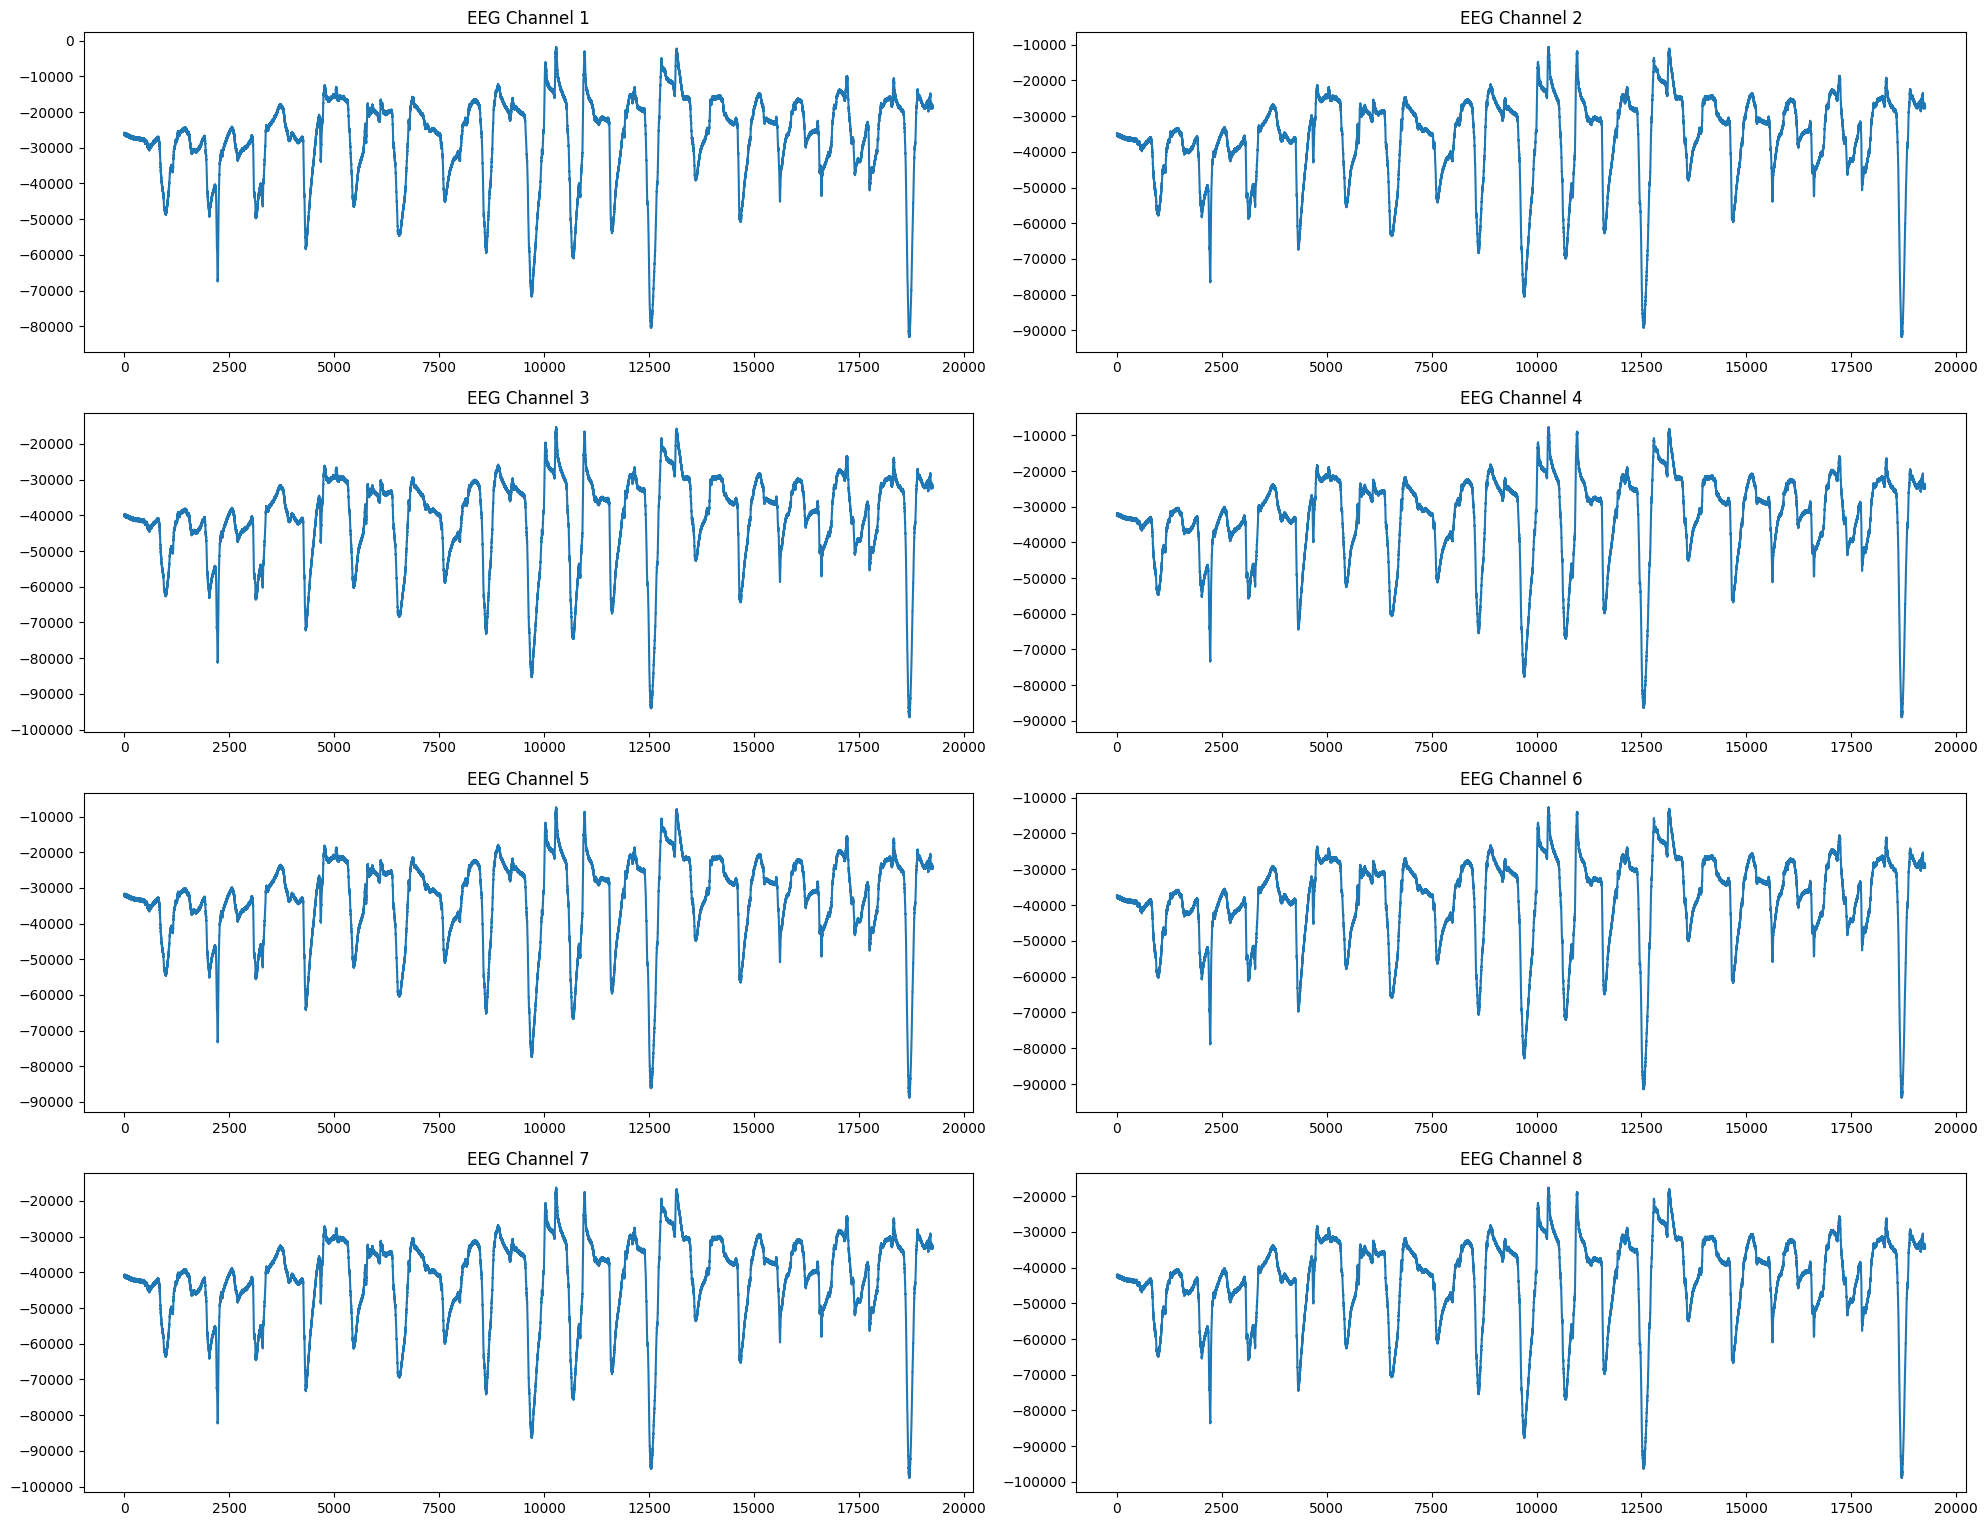

In [4]:
sub_id = "sub_2"
run_id = "run_1"
ignore = 100

eeg_data = data[sub_id][run_id]["eeg"]

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 16))

for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

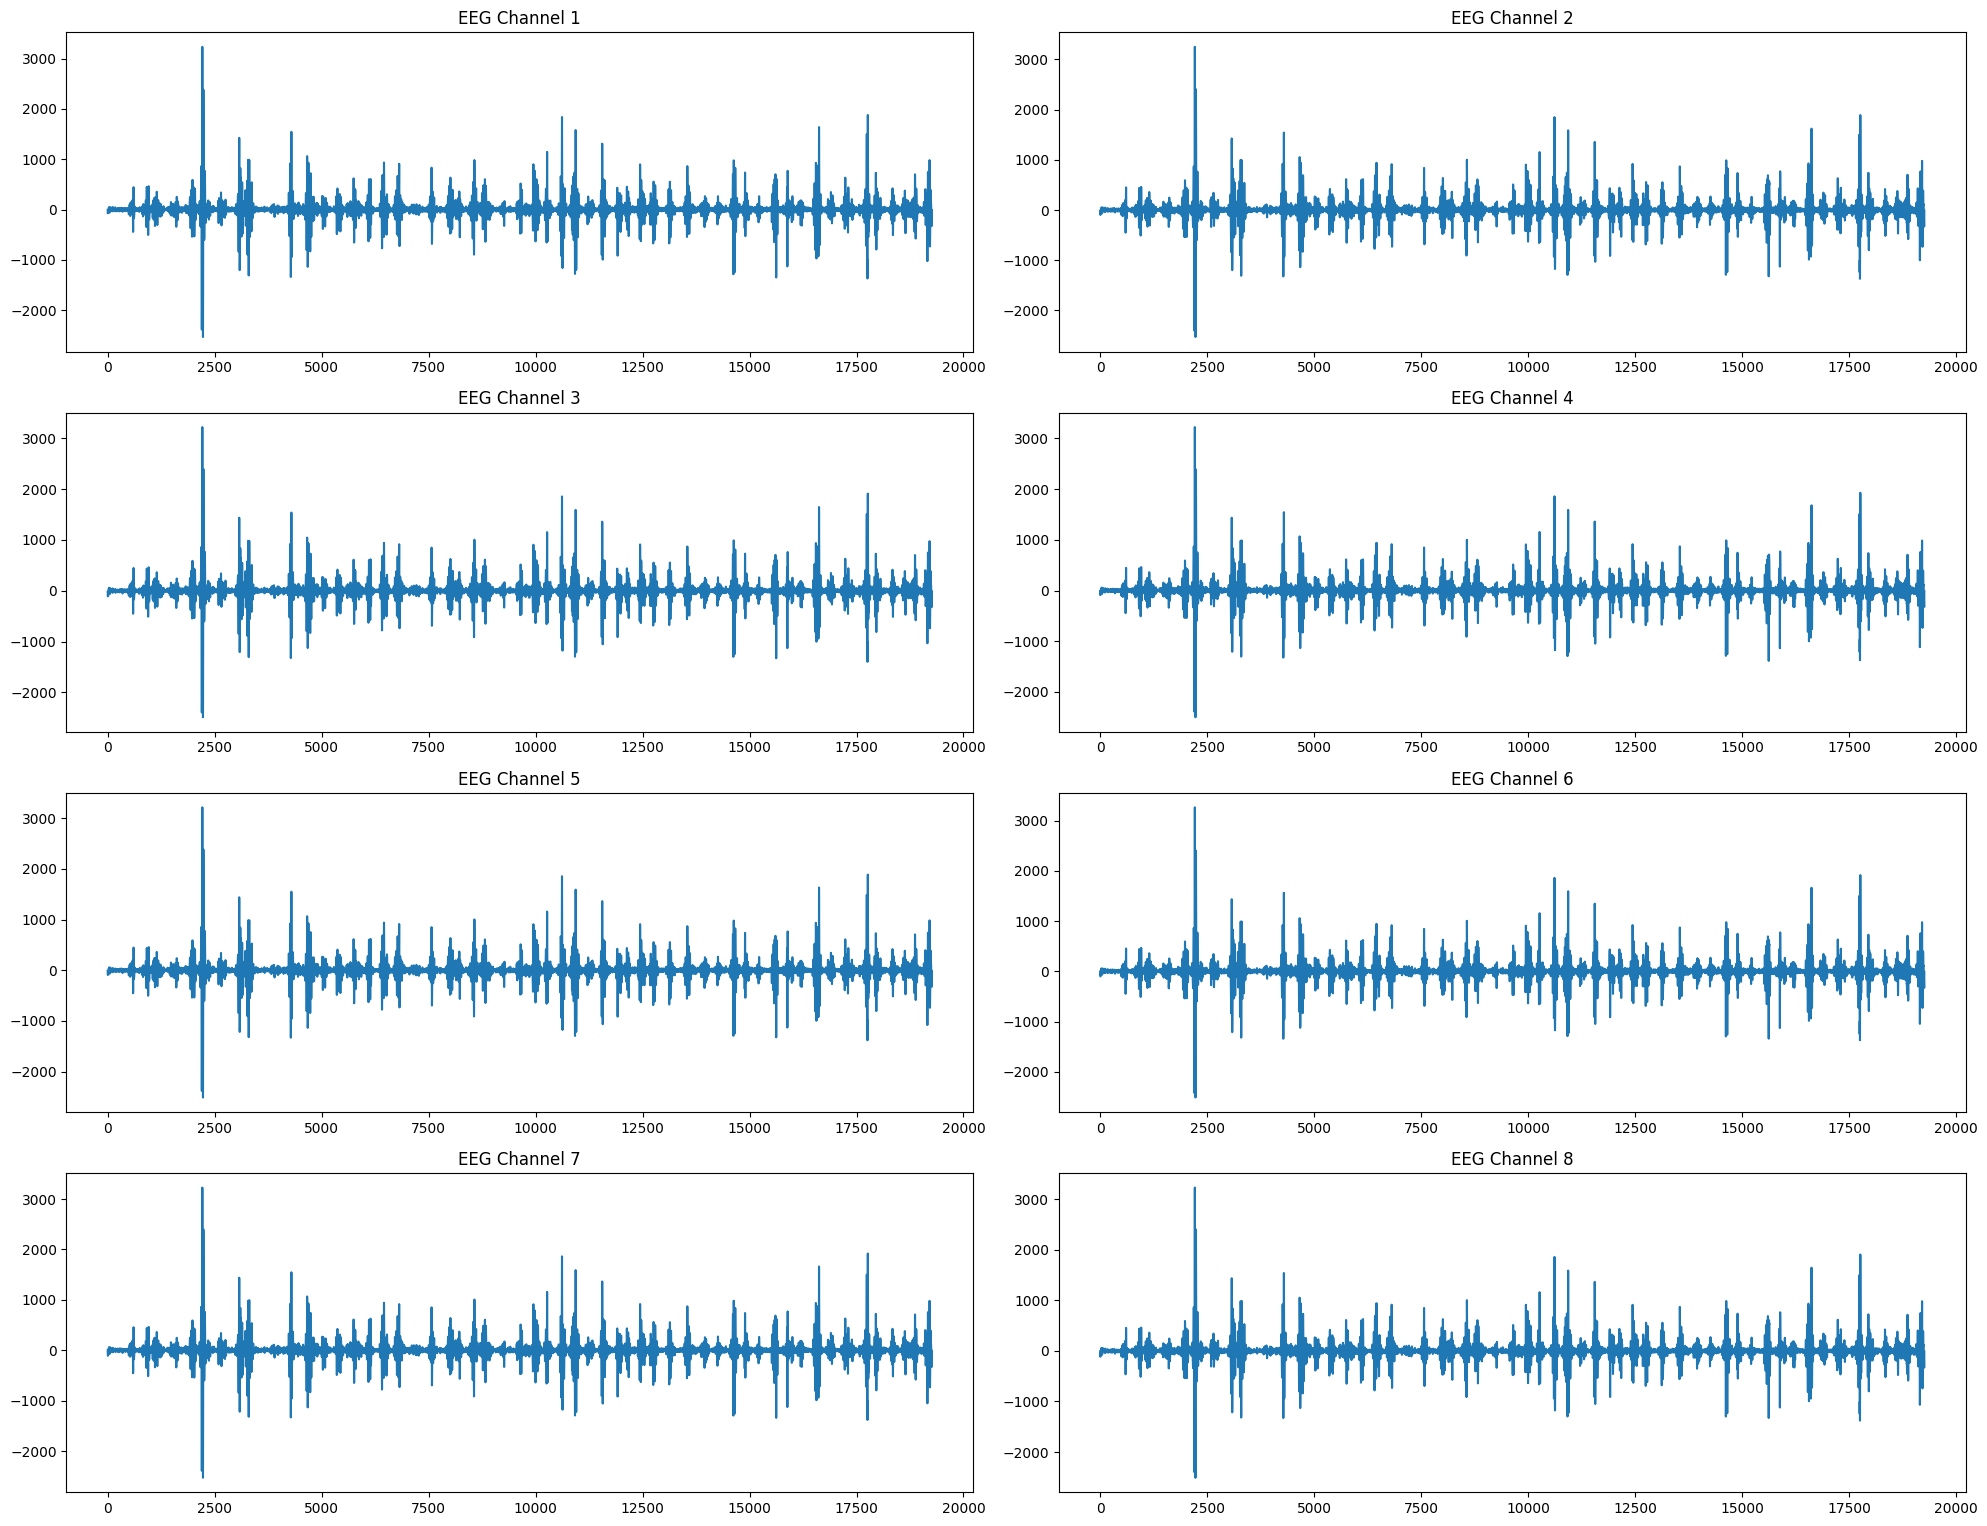

In [5]:
eeg_data = data[sub_id][run_id]["filtered_eeg"]

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 16))

for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

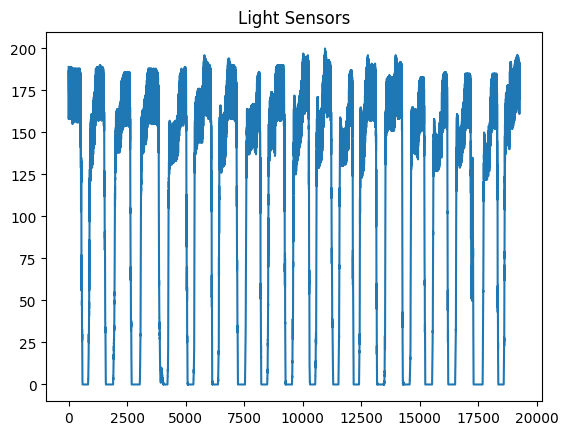

In [6]:
ignore = 100

aux_data = data[sub_id][run_id]["aux"][1]

plt.plot(np.arange(len(aux_data[ignore:])), aux_data[ignore:])
plt.title(f"Light Sensors")
plt.show()

## Cleaning the data

In [7]:
ignore = 100
pre_onset_window = 200
sample_window = 200 + pre_onset_window
cleaned_data = {}

for sub_id in list(data.keys()):
    eeg_window = []
    labels = []
    
    for run_id in list(data[sub_id].keys()):
        aux_data = data[sub_id][run_id]["aux"][1][ignore:]
        eeg_data = data[sub_id][run_id]["filtered_eeg"][:, ignore:]
        label_data = data[sub_id][run_id]["label"]
    
        labels.append(label_data)
    
        window_mask = aux_data > 10
        prev = False
        window = []
        for i, mask in enumerate(window_mask):
            if mask:
                if len(window) == 0:
                    for j in range(i-pre_onset_window, i):
                        window.append(eeg_data[:, j])
                
                window.append(eeg_data[:, i])
        
            if prev and not mask and len(window) > (100 + pre_onset_window):
                eeg_window.append(np.asarray(window))
                window = []
                
            prev = mask

    labels = np.asarray(labels).flatten()

    # asserting if data is valid
    print(len(eeg_window), len(labels))
    assert len(eeg_window) == len(labels)

    # First, split into train (70%) and temp (30%)
    eeg_train, eeg_temp, label_train, label_temp = train_test_split(
        eeg_window, labels, test_size=0.4, stratify=labels, random_state=3
    )
    
    # Split temp into validation (50%) and test (50%) ensuring stratification
    eeg_val, eeg_test, label_val, label_test = train_test_split(
        eeg_temp, label_temp, test_size=0.5, stratify=label_temp, random_state=3
    )
    
    # Store in dictionary
    cleaned_data[sub_id] = {
        "train": {"eeg": eeg_train, "label": label_train},
        "val": {"eeg": eeg_val, "label": label_val},
        "test": {"eeg": eeg_test, "label": label_test}
    }

54 54
72 72
54 54
90 90
90 90


## Dataloader

In [8]:
class Dataset(Dataset):
    def __init__(self, data: dict, mode: str, sample_window=150):
        """
        Args:
            data: (dict) cleaned data with {eeg: [c, t], label: [t]} where
                        c is channels, and t is time
            mode: (str) one of ["hand", "rps", "both"]
        """
        if mode not in ["hand", "rps", "both"]:
            raise Exception("Not a valid mode, choose one of ['hand', 'rps', 'both']")

        self.mode = mode
        self.eeg_data = data["eeg"]
        self.sample_window = sample_window
        
        if self.mode == "hand":
            self.num_classes = 2
            self.labels = []

            for l in data["label"]:
                if "right" in l:
                    self.labels.append(0)

                elif "left" in l:
                    self.labels.append(1)

                else:
                    raise Exception("incorrect label")

        elif self.mode == "rps":
            self.num_classes = 3
            self.labels = []

            for l in data["label"]:
                if "rock" in l:
                    self.labels.append(0)

                elif "paper" in l:
                    self.labels.append(1)

                elif "scissor" in l:
                    self.labels.append(2)

                else:
                    raise Exception("incorrect label")

        else:
            self.num_classes = 6
            self.labels = []
            
            mapping = {
                "left_rock": 0, 
                "left_paper": 1, 
                "left_scissors": 2, 
                "right_rock": 3, 
                "right_paper": 4, 
                "right_scissors": 5
            }
            
            for l in data["label"]:
                if l not in list(mapping.keys()):
                    raise Exception("incorrect label")

                self.labels.append(mapping[l])


    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx].transpose()[:, :self.sample_window]
        label = self.labels[idx]

        
        target = np.zeros([self.num_classes])
        target[label] = 1
        return torch.tensor(eeg).to(torch.float32), torch.tensor(target).to(torch.float32)

In [9]:
sub_ids = ["sub_1", "sub_2", "sub_3", "sub_4", "sub_5"]
mode='rps'
for sub_id in sub_ids:
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)

    print(len(train_set), len(val_set), len(test_set))

32 11 11
43 14 15
32 11 11
54 18 18
54 18 18


## Modelling Task 1: Left vs Right

In [10]:
def plot_cm(cm, sub_id):
     # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {sub_id}")
    plt.show()
    

In [11]:
batch_size = 4
epochs = 1000
num_classes = 2

mode = "hand"
results = {}
sub_ids = ["sub_1", "sub_2", "sub_3", "sub_4", "sub_5"]

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_electrodes=8, chunk_size=sample_window, num_classes=num_classes, kernel_1=8, kernel_2=8)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.unsqueeze(1))
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='binary')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 400
Epoch 100/1000, Loss: 0.3802, Val Loss: 0.5930
Epoch 200/1000, Loss: 0.3837, Val Loss: 0.5462
Epoch 300/1000, Loss: 0.3930, Val Loss: 0.6095
Epoch 400/1000, Loss: 0.3795, Val Loss: 0.7771
Epoch 500/1000, Loss: 0.3446, Val Loss: 0.7703
Epoch 600/1000, Loss: 0.3732, Val Loss: 0.7274
Epoch 700/1000, Loss: 0.3499, Val Loss: 0.5833
Epoch 800/1000, Loss: 0.3537, Val Loss: 0.5135
Epoch 900/1000, Loss: 0.3501, Val Loss: 0.6720
Epoch 1000/1000, Loss: 0.4047, Val Loss: 0.7230
============== sub_2 ==============

sample_window = 400
Epoch 100/1000, Loss: 0.5214, Val Loss: 0.6531
Epoch 200/1000, Loss: 0.5336, Val Loss: 0.7003
Epoch 300/1000, Loss: 0.5829, Val Loss: 0.6927
Epoch 400/1000, Loss: 0.5298, Val Loss: 0.6821
Epoch 500/1000, Loss: 0.5388, Val Loss: 0.6918
Epoch 600/1000, Loss: 0.5124, Val Loss: 0.7007
Epoch 700/1000, Loss: 0.5558, Val Loss: 0.7037
Epoch 800/1000, Loss: 0.5524, Val Loss: 0.6522
Epoch 900/1000, Loss: 0.4895, Val Loss:

Baseline (Random guess): 0.5
sub_1 ==> Precision: 0.6, Recall: 0.5, F1-score: 0.5454545454545454


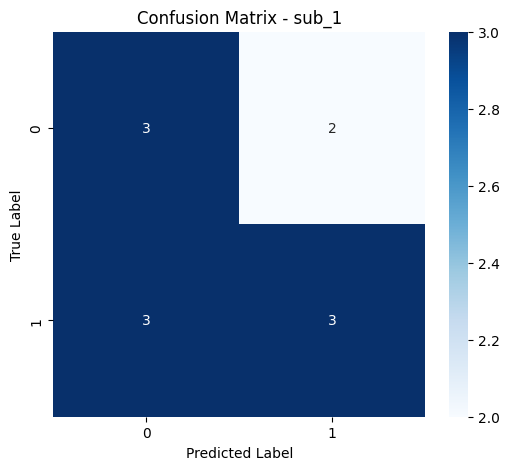

sub_2 ==> Precision: 0.6, Recall: 0.6666666666666666, F1-score: 0.631578947368421


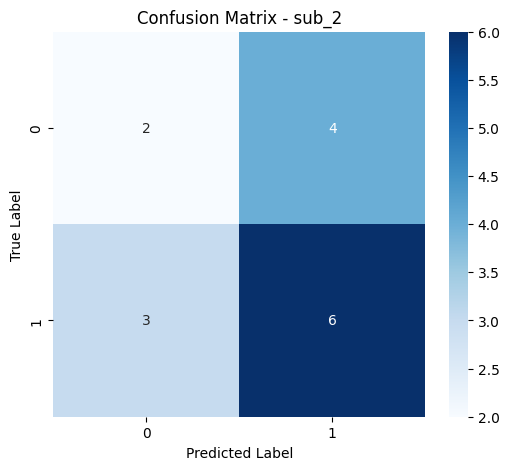

sub_3 ==> Precision: 0.5555555555555556, Recall: 0.8333333333333334, F1-score: 0.6666666666666666


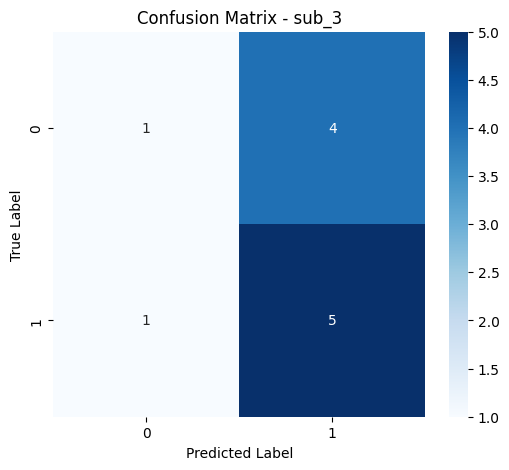

sub_4 ==> Precision: 0.5, Recall: 0.3333333333333333, F1-score: 0.4


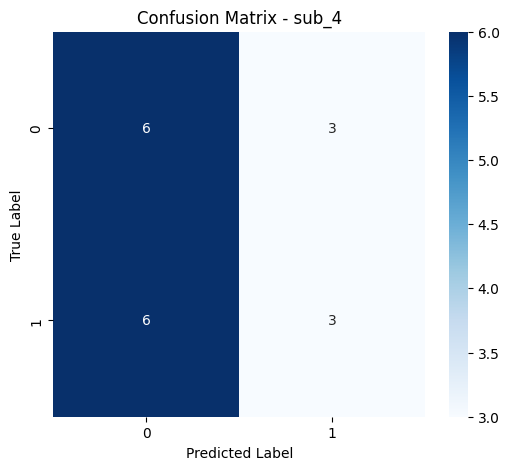

sub_5 ==> Precision: 0.3333333333333333, Recall: 0.2222222222222222, F1-score: 0.26666666666666666


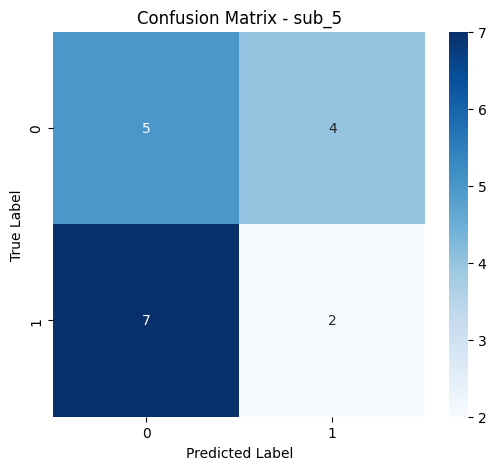

In [12]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in sub_ids:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)

## Modelling Task 2: Rock vs Paper vs Scisors

In [13]:
batch_size = 1
num_classes = 3

mode = "rps"
results = {}

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_electrodes=8, chunk_size=sample_window, num_classes=num_classes, kernel_1=8, kernel_2=8)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.unsqueeze(1))
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 400
Epoch 100/1000, Loss: 0.3375, Val Loss: 0.8959
Epoch 200/1000, Loss: 0.3500, Val Loss: 0.8061
Epoch 300/1000, Loss: 0.2911, Val Loss: 1.0821
Epoch 400/1000, Loss: 0.3001, Val Loss: 0.9208
Epoch 500/1000, Loss: 0.3263, Val Loss: 0.9110
Epoch 600/1000, Loss: 0.3248, Val Loss: 0.9086
Epoch 700/1000, Loss: 0.3665, Val Loss: 1.0500
Epoch 800/1000, Loss: 0.3385, Val Loss: 1.0540
Epoch 900/1000, Loss: 0.3624, Val Loss: 1.1429
Epoch 1000/1000, Loss: 0.3898, Val Loss: 1.0658
============== sub_2 ==============

sample_window = 400
Epoch 100/1000, Loss: 0.7149, Val Loss: 1.1335
Epoch 200/1000, Loss: 0.7161, Val Loss: 1.2252
Epoch 300/1000, Loss: 0.6983, Val Loss: 1.2252
Epoch 400/1000, Loss: 0.7314, Val Loss: 1.0803
Epoch 500/1000, Loss: 0.6955, Val Loss: 1.3166
Epoch 600/1000, Loss: 0.6937, Val Loss: 1.2340
Epoch 700/1000, Loss: 0.7238, Val Loss: 1.1681
Epoch 800/1000, Loss: 0.7122, Val Loss: 1.1710
Epoch 900/1000, Loss: 0.7156, Val Loss:

Baseline (Random guess): 0.3333333333333333
sub_1 ==> Precision: 0.125, Recall: 0.25, F1-score: 0.18181818181818182


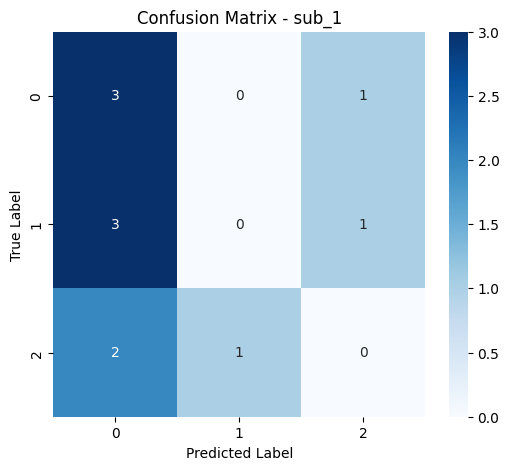

sub_2 ==> Precision: 0.2916666666666667, Recall: 0.39999999999999997, F1-score: 0.3356643356643357


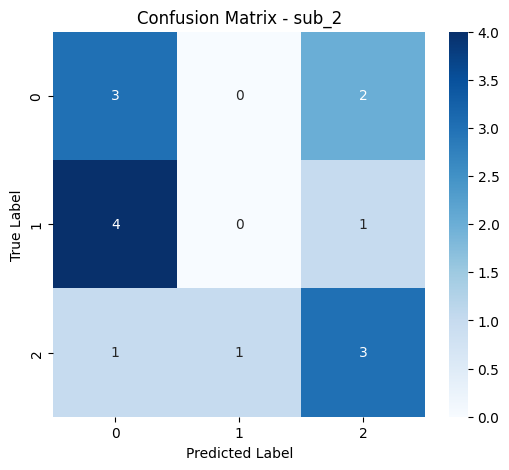

sub_3 ==> Precision: 0.125, Recall: 0.25, F1-score: 0.18181818181818182


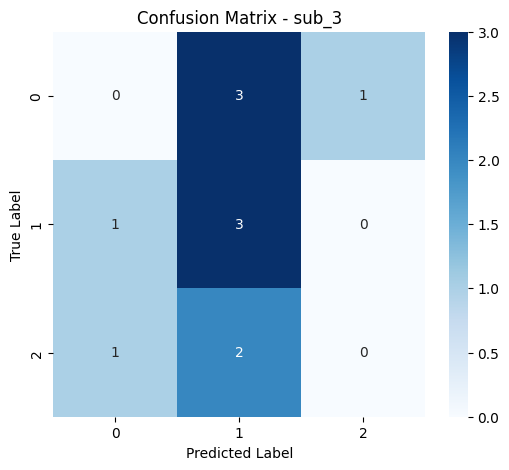

sub_4 ==> Precision: 0.41111111111111115, Recall: 0.38888888888888884, F1-score: 0.38787878787878793


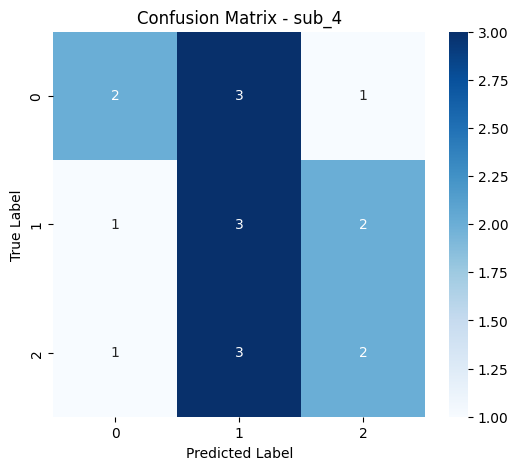

sub_5 ==> Precision: 0.5767195767195767, Recall: 0.4444444444444444, F1-score: 0.447008547008547


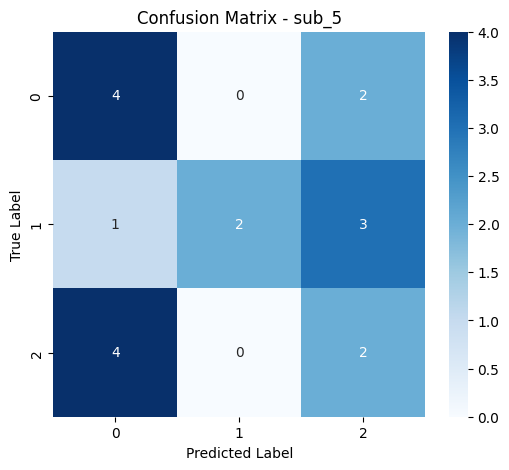

In [14]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in sub_ids:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)

## Modelling Task 3: Rock vs Paper vs Scisors

In [15]:
batch_size = 1
num_classes = 6

mode = "both"
results = {}

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_electrodes=8, chunk_size=sample_window, num_classes=num_classes, kernel_1=8, kernel_2=8)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data.unsqueeze(1))
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.unsqueeze(1))
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 400
Epoch 100/1000, Loss: 0.2011, Val Loss: 2.0378
Epoch 200/1000, Loss: 0.2024, Val Loss: 1.9475
Epoch 300/1000, Loss: 0.1992, Val Loss: 1.9784
Epoch 400/1000, Loss: 0.2046, Val Loss: 1.7346
Epoch 500/1000, Loss: 0.3467, Val Loss: 2.4405
Epoch 600/1000, Loss: 0.2487, Val Loss: 2.8713
Epoch 700/1000, Loss: 0.1944, Val Loss: 2.2659
Epoch 800/1000, Loss: 0.2918, Val Loss: 2.0720
Epoch 900/1000, Loss: 0.1338, Val Loss: 1.9402
Epoch 1000/1000, Loss: 0.2484, Val Loss: 2.6949
============== sub_2 ==============

sample_window = 400


c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.9099, Val Loss: 1.9765
Epoch 200/1000, Loss: 0.9544, Val Loss: 1.9033
Epoch 300/1000, Loss: 0.8954, Val Loss: 1.9662
Epoch 400/1000, Loss: 0.9823, Val Loss: 1.9030
Epoch 500/1000, Loss: 0.9013, Val Loss: 1.9742
Epoch 600/1000, Loss: 0.9962, Val Loss: 1.9900
Epoch 700/1000, Loss: 0.9135, Val Loss: 1.7886
Epoch 800/1000, Loss: 0.9544, Val Loss: 1.9720
Epoch 900/1000, Loss: 0.9167, Val Loss: 2.0653
Epoch 1000/1000, Loss: 0.9980, Val Loss: 2.1157
============== sub_3 ==============

sample_window = 400
Epoch 100/1000, Loss: 1.1640, Val Loss: 2.1121
Epoch 200/1000, Loss: 1.1793, Val Loss: 2.1686
Epoch 300/1000, Loss: 1.1518, Val Loss: 2.0915
Epoch 400/1000, Loss: 1.1223, Val Loss: 2.1505
Epoch 500/1000, Loss: 1.1127, Val Loss: 2.0982
Epoch 600/1000, Loss: 1.1005, Val Loss: 2.0552
Epoch 700/1000, Loss: 1.1893, Val Loss: 2.0886
Epoch 800/1000, Loss: 1.1221, Val Loss: 2.1438
Epoch 900/1000, Loss: 1.1484, Val Loss: 2.1035
Epoch 1000/1000, Loss: 1.1212, Val Loss: 2.0613
=

c:\Users\drago\anaconda3\envs\cogs_189\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.4193, Val Loss: 3.0276
Epoch 200/1000, Loss: 0.3613, Val Loss: 2.5979
Epoch 300/1000, Loss: 0.4535, Val Loss: 2.2738
Epoch 400/1000, Loss: 0.4745, Val Loss: 2.4354
Epoch 500/1000, Loss: 0.5022, Val Loss: 2.3269
Epoch 600/1000, Loss: 0.4348, Val Loss: 2.6461
Epoch 700/1000, Loss: 0.5219, Val Loss: 2.4942
Epoch 800/1000, Loss: 0.4188, Val Loss: 2.1714
Epoch 900/1000, Loss: 0.4153, Val Loss: 2.5057
Epoch 1000/1000, Loss: 0.4767, Val Loss: 2.0141
============== sub_5 ==============

sample_window = 400
Epoch 100/1000, Loss: 0.7952, Val Loss: 2.0364
Epoch 200/1000, Loss: 0.7099, Val Loss: 1.9597
Epoch 300/1000, Loss: 0.6331, Val Loss: 2.0295
Epoch 400/1000, Loss: 0.7159, Val Loss: 1.9024
Epoch 500/1000, Loss: 0.7015, Val Loss: 1.9996
Epoch 600/1000, Loss: 0.7576, Val Loss: 2.3040
Epoch 700/1000, Loss: 0.7117, Val Loss: 2.1845
Epoch 800/1000, Loss: 0.8039, Val Loss: 2.2115
Epoch 900/1000, Loss: 0.6821, Val Loss: 1.9942
Epoch 1000/1000, Loss: 0.6189, Val Loss: 2.0842


Baseline (Random guess): 0.16666666666666666
sub_1 ==> Precision: 0.041666666666666664, Recall: 0.08333333333333333, F1-score: 0.0606060606060606


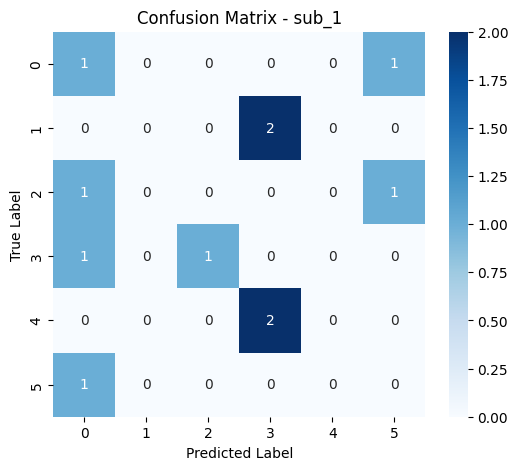

sub_2 ==> Precision: 0.19047619047619047, Recall: 0.13888888888888887, F1-score: 0.12962962962962962


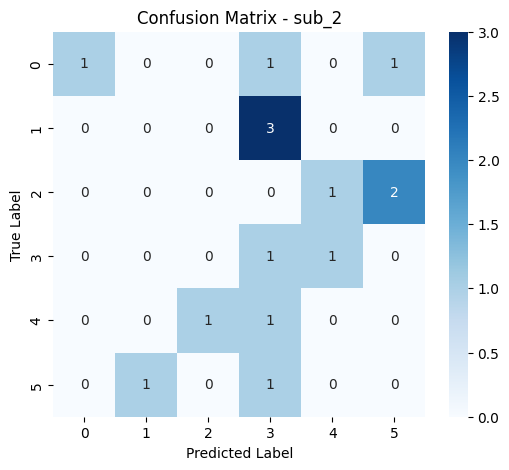

sub_3 ==> Precision: 0.20370370370370372, Recall: 0.25, F1-score: 0.18732782369146006


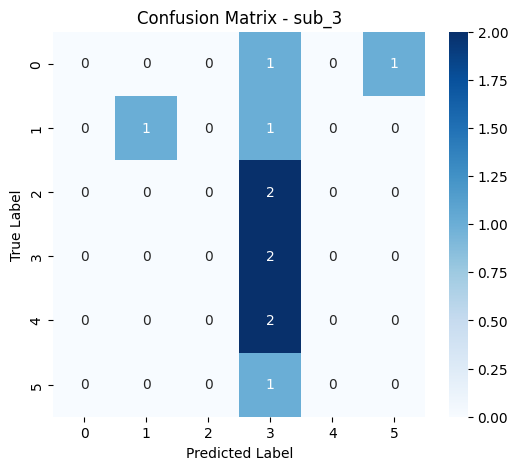

sub_4 ==> Precision: 0.10833333333333334, Recall: 0.16666666666666666, F1-score: 0.13095238095238096


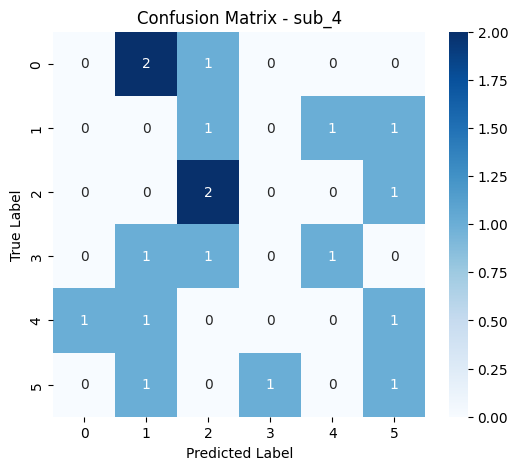

sub_5 ==> Precision: 0.4916666666666667, Recall: 0.3333333333333333, F1-score: 0.33560606060606063


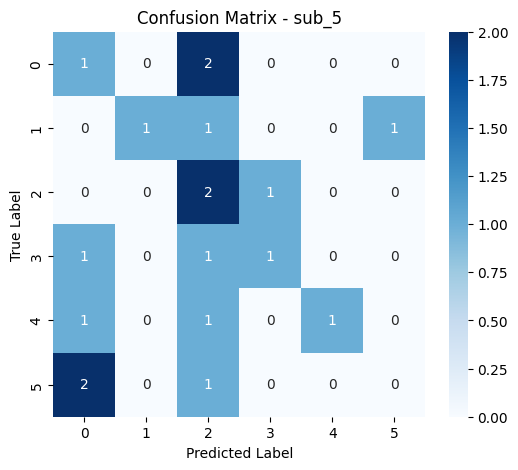

In [16]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in sub_ids:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)